In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lifelines for survival analysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines import LogNormalAFTFitter
from lifelines.datasets import load_gbsg2, load_recur
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# sksurv for Integrated Brier Score
from sksurv.metrics import integrated_brier_score, cumulative_dynamic_auc

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Loading Datasets

Lifelines provides several built-in datasets. Here are some common ones:


In [2]:
# Load a dataset (example: Waltons dataset - fruit fly survival)
# You can switch to other datasets: load_rossi(), load_dd(), load_regression_dataset()
df = load_gbsg2()


## Kaplan-Meier Estimator (Non-parametric)

The Kaplan-Meier estimator is a non-parametric method to estimate survival probabilities.


In [3]:
df.cens.unique()

array([1, 0])

In [4]:
df['event'] = 1 - df['cens']
df.event.unique()

array([0, 1])

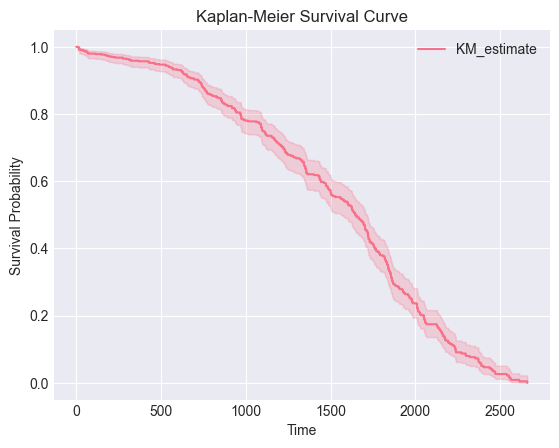


Median survival time: 1645.00


In [5]:
time_col = 'time'
event_col = 'event'

kmf = KaplanMeierFitter()
kmf.fit(df[time_col], event_observed=df[event_col])

# Plot survival curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

# Print median survival time
median_survival = kmf.median_survival_time_
print(f"\nMedian survival time: {median_survival:.2f}")


## Cox Proportional Hazards Model

The Cox model is a semi-parametric model that can incorporate covariates to predict survival.


In [6]:
df.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens,event
0,no,70,Post,21,II,3,48,66,1814,1,0
1,yes,56,Post,12,II,7,61,77,2018,1,0
2,yes,58,Post,35,II,9,52,271,712,1,0
3,yes,59,Post,17,II,4,60,29,1807,1,0
4,no,73,Post,35,II,1,26,65,772,1,0


In [7]:
def preprocess_data(df):
    data = df.dropna()
    # Convert categorical columns to one-hot encoding
    for col in data.select_dtypes(include=['object', 'category']).columns:
        dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data = pd.concat([data.drop(columns=[col]), dummies], axis=1)
    return data

In [8]:
# Prepare data for Cox model
# Identify which columns are covariates (not time or event)
cens_col = 'cens'
covariate_cols = [col for col in df.columns if col not in [time_col, event_col, cens_col]]

print(f"Covariates to use: {covariate_cols}")

# Fit Cox Proportional Hazards model
cph = CoxPHFitter()

# Create a dataframe with time, event, and covariates
model_df = preprocess_data(df)


# Standardize numerical columns (except time and event columns)
numerical_cols = model_df.select_dtypes(include=['int64', 'float64']).columns
# Exclude duration and event columns from standardization
numerical_cols = [col for col in numerical_cols if col not in [time_col, event_col, cens_col]]

scaler = StandardScaler()
model_df[numerical_cols] = scaler.fit_transform(model_df[numerical_cols])

Covariates to use: ['horTh', 'age', 'menostat', 'tsize', 'tgrade', 'pnodes', 'progrec', 'estrec']


In [9]:
model_df = model_df.drop(columns=[cens_col])

In [10]:
df_train, df_test = train_test_split(model_df, test_size=0.2, random_state=42)

In [11]:
df_train.shape, df_test.shape

((548, 11), (138, 11))

In [12]:
cph.fit(df_train, duration_col=time_col, event_col=event_col)

# Print summary
print("\nCox Model Summary:")
cph.print_summary()



Cox Model Summary:


<lifelines.CoxPHFitter: fitted with 548 total observations, 239 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 548
number of events observed = 309
   partial log-likelihood = -1534.74
         time fit was run = 2025-12-16 15:56:20 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
age          -0.09      0.91      0.10           -0.28            0.10                0.76                1.10
tsize         0.03      1.03      0.06           -0.09            0.14                0.92                1.15
pnodes        0.09      1.09      0.08           -0.07            0.25                0.93                1.28
progrec       0.11      1.12      0.06           -0.02            0.23                0.98                1.26
estrec       -0.01      0.99      0.07           -0.15            0.14                0.86                1.15
horTh_yes    -0.20      0.82      0.12           -0.43            0.04                0.65                1.04
menostat_Pre -0.07      0.94      0.18           -0.42            0.29                0.66                1.33
tgrade_II    -0.13      0.88      0.16           -0.45            0.19                0.64                1.21
tgrade_III    0.14      1.15      0.19           -0.24            0.52                0.79                1.68

              cmp to     z    p  -log2(p)
covariate                                
age             0.00 -0.94 0.35      1.52
tsize           0.00  0.47 0.64      0.64
pnodes          0.00  1.08 0.28      1.84
progrec         0.00  1.71 0.09      3.52
estrec          0.00 -0.07 0.94      0.09
horTh_yes       0.00 -1.61 0.11      3.22
menostat_Pre    0.00 -0.37 0.71      0.49
tgrade_II       0.00 -0.78 0.44      1.19
tgrade_III      0.00  0.74 0.46      1.12
---
Concordance = 0.55
Partial AIC = 3087.48
log-likelihood ratio test = 12.52 on 9 df
-log2(p) of ll-ratio test = 2.43

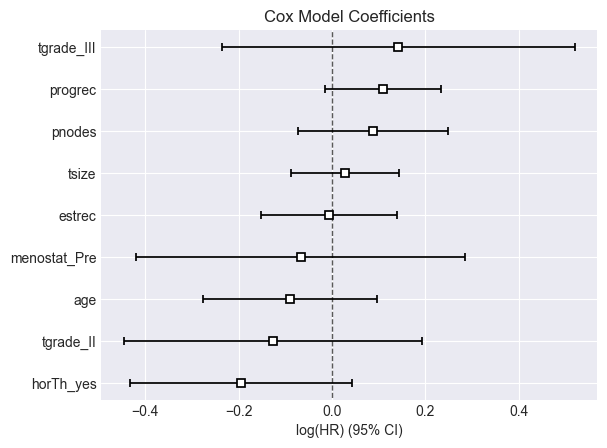

In [13]:
# Visualize coefficients
if len(covariate_cols) > 0:
    cph.plot()
    plt.title('Cox Model Coefficients')
    plt.show()
    
    # Plot partial effects
    if len(covariate_cols) == 1:
        cph.plot_partial_effects_on_outcome(covariates=covariate_cols[0], values=[0, 1] if df[covariate_cols[0]].dtype == 'int64' else None)
        plt.title(f'Partial Effects of {covariate_cols[0]}')
        plt.show()


Survival predictions for sample individuals:
           286       652       257       336       318
8.0   0.998780  0.998472  0.998642  0.998238  0.996888
15.0  0.997559  0.996943  0.997284  0.996476  0.993780
16.0  0.996337  0.995414  0.995924  0.994713  0.990674
17.0  0.993891  0.992354  0.993204  0.991189  0.984477
18.0  0.992665  0.990821  0.991841  0.989424  0.981380


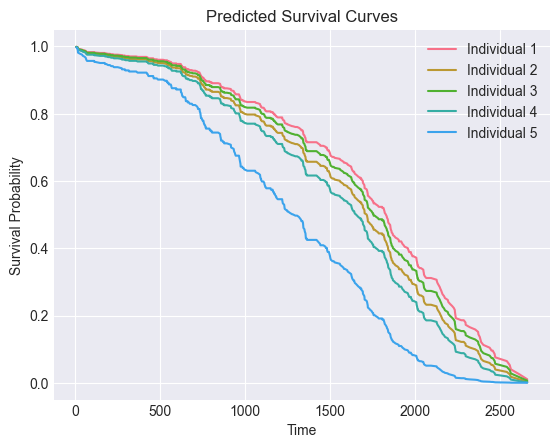

In [14]:
# Predict survival for new data (if covariates exist)
if len(covariate_cols) > 0:
    # Example: predict survival for first few individuals
    sample_data = df_test.iloc[:5].copy()
    sample_data = sample_data.drop(columns=[time_col, event_col])
    
    # Predict survival probabilities at different time points
    survival_predictions = cph.predict_survival_function(sample_data)
    
    print("Survival predictions for sample individuals:")
    print(survival_predictions.head())
    
    # Plot predicted survival curves
    ax = plt.subplot(111)
    for i in range(min(5, len(sample_data))):
        survival_predictions.iloc[:, i].plot(ax=ax, label=f'Individual {i+1}')
    plt.title('Predicted Survival Curves')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()


### Model Evaluation

Evaluate the performance of your survival model.

**Helper function for Integrated Brier Score**


In [ ]:
def compute_ibs(df_train, df_test, test_surv, time_col='time', event_col='event', times=None):
    """
    Compute Integrated Brier Score (IBS) using sksurv.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data with time_col and event_col
    df_test : DataFrame
        Test data with time_col and event_col
    test_surv : DataFrame or array
        Survival predictions. If DataFrame (from lifelines), index should be times.
        If array, should be (n_samples, n_times) and times parameter must be provided.
    time_col : str
        Name of time column
    event_col : str
        Name of event column
    times : array-like, optional
        Time points for survival predictions (required if test_surv is array)
    
    Returns:
    --------
    ibs : float
        Integrated Brier Score (lower is better)
    """
    # Create structured arrays for sksurv
    y_train = np.array([(bool(e), float(t)) for e, t in zip(df_train[event_col].values, df_train[time_col].values)], 
                       dtype=[('event', bool), ('time', float)])
    y_test = np.array([(bool(e), float(t)) for e, t in zip(df_test[event_col].values, df_test[time_col].values)], 
                      dtype=[('event', bool), ('time', float)])
    
    # Extract times and survival predictions
    if isinstance(test_surv, pd.DataFrame):
        # DataFrame from lifelines: index is times
        times = test_surv.index.values
        surv_pred_matrix = test_surv.values.T
    else:
        # numpy array: times must be provided
        if times is None:
            raise ValueError("times parameter required when test_surv is an array")
        surv_pred_matrix = test_surv
    
    # Filter to test data range
    test_time_min, test_time_max = df_test[time_col].min(), df_test[time_col].max()
    mask = (times >= test_time_min) & (times < test_time_max)
    times = times[mask]
    surv_pred_matrix = surv_pred_matrix[:, mask]
    
    return integrated_brier_score(y_train, y_test, surv_pred_matrix, times)


def compute_auc(df_train, df_test, test_surv, time_col='time', event_col='event', times=None):
    """
    Compute AUC using sksurv.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data with time_col and event_col
    df_test : DataFrame
        Test data with time_col and event_col
    test_surv : DataFrame or array
        Survival predictions. If DataFrame (from lifelines), index should be times.
        If array, should be (n_samples, n_times) and times parameter must be provided.
    time_col : str
        Name of time column
    event_col : str
        Name of event column
    times : array-like, optional
        Time points for survival predictions (required if test_surv is array)
    
    Returns:
    --------
    ibs : float
        Integrated Brier Score (lower is better)
    """
    # Create structured arrays for sksurv
    y_train = np.array([(bool(e), float(t)) for e, t in zip(df_train[event_col].values, df_train[time_col].values)], 
                       dtype=[('event', bool), ('time', float)])
    y_test = np.array([(bool(e), float(t)) for e, t in zip(df_test[event_col].values, df_test[time_col].values)], 
                      dtype=[('event', bool), ('time', float)])
    
    # Extract times and survival predictions
    if isinstance(test_surv, pd.DataFrame):
        # DataFrame from lifelines: index is times
        times = test_surv.index.values
        surv_pred_matrix = test_surv.values.T
    else:
        # numpy array: times must be provided
        if times is None:
            raise ValueError("times parameter required when test_surv is an array")
        surv_pred_matrix = test_surv
    
    # Filter to test data range
    test_time_min, test_time_max = df_test[time_col].min(), df_test[time_col].max()
    mask = (times >= test_time_min) & (times < test_time_max)
    times = times[mask]
    surv_pred_matrix = surv_pred_matrix[:, mask]
    
    return cumulative_dynamic_auc(y_train, y_test, surv_pred_matrix, times)

# # Concordance index (C-index) - measures model discrimination
# # Higher is better (range: 0-1, where 0.5 is random, 1.0 is perfect)
# if len(covariate_cols) > 0:
#     c_index = cph.concordance_index_
#     print(f"C-index (Concordance): {c_index:.4f}")
#     print(f"Interpretation: {'Good' if c_index > 0.7 else 'Moderate' if c_index > 0.6 else 'Poor'} discrimination")
    
#     # Check proportional hazards assumption
#     print("\nChecking proportional hazards assumption...")
#     cph.check_assumptions(df_train, p_value_threshold=0.05, show_plots=True)


In [16]:
t_grid = np.arange(8, 2659)

test_surv = cph.predict_survival_function(df_test, t_grid)
test_median = cph.predict_median(df_test)
test_partial_hazard = cph.predict_partial_hazard(df_test)

In [17]:
test_surv.shape, t_grid.shape

((2651, 138), (2651,))

In [18]:
# Compute CI and IBS on test set for Cox model
ci_cox = concordance_index(
    event_times=df_test.time,
    event_observed=df_test.event,
    predicted_scores=test_median
)
print(f"C-index on test set: {ci_cox:.4f}")

ibs_cph_test = compute_ibs(df_train, df_test, test_surv, time_col, event_col)
print(f"IBS on test set: {ibs_cph_test:.4f}")

auc_cph = compute_auc(df_train, df_test, test_surv, time_col, event_col)
auc_cph


C-index on test set: 0.5603
IBS on test set: 0.1209


(array([0.95620438, 0.95620438, 0.95620438, ..., 0.02530678, 0.02530678,
        0.02530678]),
 np.float64(0.38374849689322454))

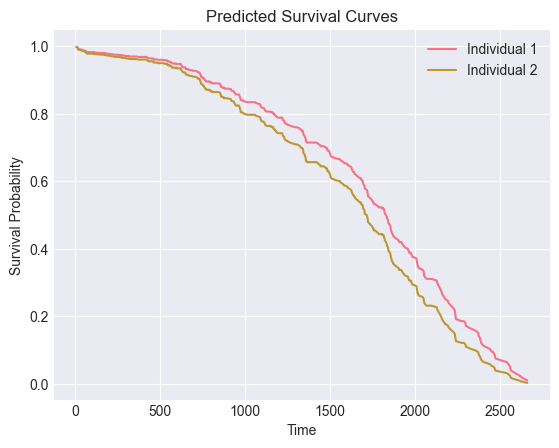

In [19]:
# Plot predicted survival curves
ax = plt.subplot(111)
for i in range(min(2, len(sample_data))):
    test_surv.iloc[:, i].plot(ax=ax, label=f'Individual {i+1}')
plt.title('Predicted Survival Curves')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [20]:
test_surv.iloc[:,0]

8.0       0.998780
9.0       0.998605
10.0      0.998431
11.0      0.998256
12.0      0.998082
            ...   
2654.0    0.011557
2655.0    0.011342
2656.0    0.011131
2657.0    0.010925
2658.0    0.010721
Name: 286, Length: 2651, dtype: float64

In [21]:
ibs_cox = compute_ibs(df_train, df_test, test_surv, time_col, event_col)
print(f"IBS: {ibs_cox:.4f}")

IBS: 0.1209


## AFT model for survival

In [22]:
# Fit log-normal AFT model on training set
aft = LogNormalAFTFitter()

# Get covariates (all columns except time and event)
covariate_cols = [col for col in df_train.columns if col not in [time_col, event_col]]
print(f"Fitting log-normal AFT model with covariates: {covariate_cols}")

# Fit the model
aft.fit(df_train, duration_col=time_col, event_col=event_col)

# Print model summary
print("\nLog-Normal AFT Model Summary:")
aft.print_summary()

# Compute concordance index on test set
# Predict median survival time for test set
test_median_pred = aft.predict_median(df_test)

# Compute concordance index
# Note: For AFT models, higher predicted median = longer survival = lower risk
# So we can use the median directly as the score
c_index_aft = concordance_index(
    event_times=df_test[time_col],
    predicted_scores=test_median_pred,
    event_observed=df_test[event_col]
)

print(f"\nConcordance Index (C-index) on test set: {c_index_aft:.4f}")
print(f"Interpretation: {'Good' if c_index_aft > 0.7 else 'Moderate' if c_index_aft > 0.6 else 'Poor'} discrimination")

# Compute Integrated Brier Score on test set
test_surv_aft = aft.predict_survival_function(df_test.drop(columns=[time_col, event_col]))
ibs_aft = compute_ibs(df_train, df_test, test_surv_aft, time_col, event_col)
print(f"\nIntegrated Brier Score (IBS) on test set: {ibs_aft:.4f}")
print(f"Interpretation: {'Good' if ibs_aft < 0.25 else 'Moderate' if ibs_aft < 0.3 else 'Poor'} calibration (lower is better)")

Fitting log-normal AFT model with covariates: ['age', 'tsize', 'pnodes', 'progrec', 'estrec', 'horTh_yes', 'menostat_Pre', 'tgrade_II', 'tgrade_III']

Log-Normal AFT Model Summary:


<lifelines.LogNormalAFTFitter: fitted with 548 total observations, 239 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 548
number of events observed = 309
           log-likelihood = -2670.53
         time fit was run = 2025-12-16 15:56:20 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                     
mu_    age          -0.05      0.95      0.08           -0.20            0.09                0.82                1.10
       estrec        0.05      1.05      0.06           -0.06            0.16                0.94                1.18
       horTh_yes     0.04      1.04      0.10           -0.16            0.24                0.85                1.27
       menostat_Pre -0.23      0.79      0.15           -0.52            0.05                0.60                1.06
       pnodes       -0.02      0.98      0.05           -0.13            0.08                0.88                1.09
       progrec      -0.05      0.95      0.05           -0.14            0.04                0.87                1.04
       tgrade_II     0.17      1.18      0.14           -0.10            0.44                0.90                1.56
       tgrade_III    0.10      1.10      0.16           -0.22            0.42                0.80                1.52
       tsize         0.00      1.00      0.05           -0.10            0.10                0.91                1.11
       Intercept     7.24   1388.03      0.15            6.94            7.53             1036.57             1858.65
sigma_ Intercept    -0.06      0.94      0.04           -0.14            0.01                0.87                1.01

                     cmp to     z      p  -log2(p)
param  covariate                                  
mu_    age             0.00 -0.73   0.47      1.10
       estrec          0.00  0.91   0.36      1.46
       horTh_yes       0.00  0.40   0.69      0.54
       menostat_Pre    0.00 -1.59   0.11      3.15
       pnodes          0.00 -0.44   0.66      0.60
       progrec         0.00 -1.15   0.25      2.00
       tgrade_II       0.00  1.21   0.22      2.15
       tgrade_III      0.00  0.60   0.55      0.86
       tsize           0.00  0.08   0.94      0.09
       Intercept       0.00 48.57 <0.005       inf
sigma_ Intercept       0.00 -1.60   0.11      3.19
---
Concordance = 0.54
AIC = 5363.06
log-likelihood ratio test = 7.47 on 9 df
-log2(p) of ll-ratio test = 0.77


Concordance Index (C-index) on test set: 0.5304
Interpretation: Poor discrimination

Integrated Brier Score (IBS) on test set: 0.1497
Interpretation: Good calibration (lower is better)


In [23]:
auc_aft = compute_auc(df_train, df_test, test_surv_aft, time_col, event_col)
auc_aft

(array([0.75912409, 0.75912409, 0.75912409, 0.75912409, 0.75735294,
        0.75735294, 0.75735294, 0.75735294, 0.67101335, 0.67101335,
        0.67101335, 0.67101335, 0.66853977, 0.66853977, 0.66853977,
        0.6660287 , 0.6660287 , 0.6660287 , 0.6660287 , 0.66858299,
        0.66858299, 0.66858299, 0.66858299, 0.66858299, 0.66858299,
        0.66601387, 0.66601387, 0.66601387, 0.66601387, 0.66601387,
        0.52390936, 0.52390936, 0.48774471, 0.48774471, 0.48367919,
        0.48367919, 0.49350802, 0.49350802, 0.49350802, 0.49350802,
        0.49350802, 0.49350802, 0.49755317, 0.49755317, 0.49755317,
        0.49758623, 0.49766886, 0.49766886, 0.50195911, 0.50195911,
        0.50421883, 0.50421883, 0.50421883, 0.50421883, 0.50421883,
        0.50421883, 0.49986987, 0.49986987, 0.49986987, 0.49986987,
        0.49986987, 0.49986987, 0.49986987, 0.49986987, 0.49986987,
        0.49986987, 0.49986987, 0.49986987, 0.49986987, 0.49986987,
        0.49997563, 0.49997563, 0.50008328, 0.50

## Helper functions

In [24]:
EPS = 1e-12

def survival_lognormal(t, mu_log, sigma):
    """
    S(t | x) under log-normal AFT: log T ~ N(mu_log, sigma^2)
    t: array-like positive times
    mu_log: array-like same shape (or broadcastable), mean of log T
    sigma: positive scalar
    """
    t = np.asarray(t, dtype=float)
    mu_log = np.asarray(mu_log, dtype=float)
    z = (np.log(np.clip(t, EPS, None)) - mu_log) / sigma
    # survival = 1 - Phi(z)
    return norm.sf(z)  # numerically stable

def neg_loglik_sigma(sigma_raw, y, delta, mu_log):
    """
    Negative censored log-likelihood as a function of sigma.
    sigma_raw is unconstrained; sigma = softplus(sigma_raw) for positivity.
    """
    # softplus to ensure sigma > 0
    sigma = np.log1p(np.exp(sigma_raw)) + 1e-8

    y = np.asarray(y, dtype=float)
    delta = np.asarray(delta, dtype=float)
    mu_log = np.asarray(mu_log, dtype=float)

    logy = np.log(np.clip(y, EPS, None))
    z = (logy - mu_log) / sigma

    # log pdf of log-normal with parameters (mu_log, sigma):
    # f(y) = (1/(y*sigma)) * phi(z)
    log_pdf = -np.log(np.clip(y, EPS, None)) - np.log(sigma) + norm.logpdf(z)

    # log survival
    log_sf = norm.logsf(z)  # stable log(1 - Phi(z))

    ll = delta * log_pdf + (1.0 - delta) * log_sf
    return -np.sum(ll)

def fit_sigma_lognormal(y, delta, mu_pred, mu_is="median"):
    """
    Fit sigma with mu fixed.

    Parameters
    ----------
    y : array (n,)
        observed times (event or censoring time): y = min(T, C)
    delta : array (n,)
        event indicator: 1 if event observed, 0 if right-censored
    mu_pred : array (n,)
        pretrained model output per sample
        - if mu_is="logmean", mu_pred is mu_log = E[log T | x]
        - if mu_is="median", mu_pred is median time on original scale
    mu_is : {"median", "logmean"}
    """
    y = np.asarray(y, dtype=float)
    delta = np.asarray(delta, dtype=float)
    mu_pred = np.asarray(mu_pred, dtype=float)

    if mu_is == "logmean":
        mu_log = mu_pred
    elif mu_is == "median":
        mu_log = np.log(np.clip(mu_pred, EPS, None))
    else:
        raise ValueError("mu_is must be 'median' or 'logmean'.")

    res = minimize(
        fun=lambda sraw: neg_loglik_sigma(sraw, y=y, delta=delta, mu_log=mu_log),
        x0=np.array([0.0]),  # initial sigma_raw
        method="L-BFGS-B",
    )

    sigma_hat = np.log1p(np.exp(res.x[0])) + 1e-8
    return sigma_hat, res

# ---- Example usage ----
# y: observed times
# delta: 1=event, 0=censored
# mu_pred: pretrained predicted time (e.g. median time)
# sigma_hat, opt_res = fit_sigma_lognormal(y, delta, mu_pred, mu_is="median")

# Then compute survival curves:
# t_grid = np.arange(1, 101)
# mu_log = np.log(np.clip(mu_pred, EPS, None))
# S = survival_lognormal(t_grid[None, :], mu_log[:, None], sigma_hat)

In [25]:
def predicted_median_time_from_survival(S, t_grid):
    """
    S: (n, T) survival probs
    t_grid: (T,) increasing times
    returns: (n,) predicted median times (first t where S(t) <= 0.5),
             or np.inf if never crosses 0.5 within horizon.
    """
    S = np.asarray(S)
    t_grid = np.asarray(t_grid)

    crossed = S <= 0.5                           # (n, T) boolean
    has_cross = crossed.any(axis=1)              # (n,)

    # argmax gives first True only if any True exists; otherwise returns 0
    first_idx = crossed.argmax(axis=1)           # (n,)

    med = np.full(S.shape[0], np.inf, dtype=float)
    med[has_cross] = t_grid[first_idx[has_cross]]
    return med

## Using TabPFN for survival analysis

In [26]:
from tabpfn import TabPFNRegressor
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

In [27]:
model = TabPFNRegressor(device="cpu")

In [28]:
y_train = df_train.time
X_train = df_train.drop(columns=['time'])
X_train_uncensored = X_train[X_train.event == 1].drop(columns=['event'])
y_train_uncensored = y_train[X_train.event == 1]


y_test = df_test.time
X_test = df_test.drop(columns=['time'])
X_test_uncensored = X_test[X_test.event == 1].drop(columns=['event'])
y_test_uncensored = y_test[X_test.event == 1]

model.fit(X_train_uncensored, y_train_uncensored)

preds = model.predict(X_test_uncensored, output_type="median")

/Users/mariana/.Envs/pycox/lib/python3.12/site-packages/tabpfn/regressor.py:649: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


In [29]:
mu_pred = model.predict(X_train.drop(columns=['event']), output_type="median")

In [30]:
sigma_hat, opt_res = fit_sigma_lognormal(y_train, X_train.event, mu_pred, mu_is="median")

In [31]:
df.time.min(), df.time.max()

(np.int64(8), np.int64(2659))

In [32]:
opt_res

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2673.1713926026887
        x: [ 4.335e-01]
      nit: 6
      jac: [ 0.000e+00]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [33]:
X_test.head()

,age,tsize,pnodes,progrec,estrec,event,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
286,0.390327,-1.563053,-0.732927,-0.539091,-0.622676,1,True,False,True,False
652,-0.301826,1.446931,0.180901,-0.539091,-0.616139,1,True,False,True,False
257,-0.202947,-0.303060,-0.732927,0.281943,0.083334,1,True,True,True,False
336,-1.488376,-0.373059,-0.367396,-0.479739,-0.596527,1,False,True,True,False
318,-0.202947,0.046939,-0.550162,5.153742,-0.380802,1,True,True,False,True


In [34]:
t_grid = np.arange(8, 2659)
mu_pred = model.predict(X_test.drop(columns=['event']), output_type="median")
mu_log = np.log(np.clip(mu_pred, EPS, None))
S = survival_lognormal(t_grid[None, :], mu_log[:, None], sigma_hat)

In [35]:
# --- compute predicted medians ---
med_pred = predicted_median_time_from_survival(S, t_grid)

# lifelines expects a "score" where higher = longer survival
# Here larger median => longer survival, so we can pass med_pred directly.
# If you use a risk score instead, pass -med_pred.
ci_tabpfn = concordance_index(y_test, med_pred, event_observed=X_test.event)

print("Harrell's C-index:", ci_tabpfn)

# Compute Integrated Brier Score for TabPFN model
ibs_tabpfn = compute_ibs(df_train, df_test, S, time_col, event_col, times=t_grid)
print(f"Integrated Brier Score (IBS) on test set: {ibs_tabpfn:.4f}")
print(f"Interpretation: {'Good' if ibs_tabpfn < 0.25 else 'Moderate' if ibs_tabpfn < 0.3 else 'Poor'} calibration (lower is better)")

Harrell's C-index: 0.578712220762155
Integrated Brier Score (IBS) on test set: 0.1459
Interpretation: Good calibration (lower is better)


In [36]:
auc_tabpfn = compute_auc(df_train, df_test, S, time_col, event_col, times=t_grid)
auc_tabpfn

(array([0.34306569, 0.34306569, 0.34306569, ..., 0.35752701, 0.35752701,
        0.35752701]),
 np.float64(0.35000390036382134))

## Ablation: would a dummy model -- random weights -- work as well?

In [37]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="median")  # or "mean"
dummy.fit(X_train_uncensored, y_train_uncensored)        # use uncensored only (since y is event time)
mu_pred_train = dummy.predict(X_train) # or X_train if you only need it there
mu_pred_test  = dummy.predict(X_test)

In [38]:
sigma_hat2, opt_res2 = fit_sigma_lognormal(y_train, X_train.event, mu_pred_train, mu_is="median")

In [39]:
sigma_hat2

np.float64(0.943601520295937)

In [40]:
mu_log = np.log(np.clip(mu_pred_test, EPS, None))
S_2 = survival_lognormal(t_grid[None, :], mu_log[:, None], sigma_hat2)

In [41]:
med_pred_2 = predicted_median_time_from_survival(S_2, t_grid)
c_index_2 = concordance_index(y_test, med_pred_2, event_observed=X_test.event)

print(f"Dummy model C-index: {c_index_2:.4f}")

# Compute Integrated Brier Score for dummy model
ibs_dummy = compute_ibs(df_train, df_test, S_2, time_col, event_col, times=t_grid)
print(f"Dummy model IBS: {ibs_dummy:.4f}")
print(f"Interpretation: {'Good' if ibs_dummy < 0.25 else 'Moderate' if ibs_dummy < 0.3 else 'Poor'} calibration (lower is better)")

Dummy model C-index: 0.5000
Dummy model IBS: 0.1476
Interpretation: Good calibration (lower is better)


In [42]:
auc_dummy = compute_auc(df_train, df_test, S_2, time_col, event_col, times=t_grid)
auc_dummy

(array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]), np.float64(0.5000000000000001))

In [43]:
c_index_2

np.float64(0.5)

## Model Comparison

Compare all survival analysis strategies across multiple metrics.

In [44]:
# Collect all metrics for comparison
# Create comparison dataframe
comparison_data = pd.DataFrame({
    'Model': ['Cox PH', 'Log-Normal AFT', 'TabPFN', 'Dummy'],
    'C-index': [ci_cox, c_index_aft, ci_tabpfn, c_index_2],
    'IBS': [ibs_cph_test, ibs_aft, ibs_tabpfn, ibs_dummy]
})

print("Model Performance Comparison:")
print(comparison_data.to_string(index=False))
print("\nNote: For C-index, higher is better. For IBS, lower is better.")


Model Performance Comparison:
         Model  C-index      IBS
        Cox PH 0.560315 0.120866
Log-Normal AFT 0.530355 0.149726
        TabPFN 0.578712 0.145865
         Dummy 0.500000 0.147618

Note: For C-index, higher is better. For IBS, lower is better.


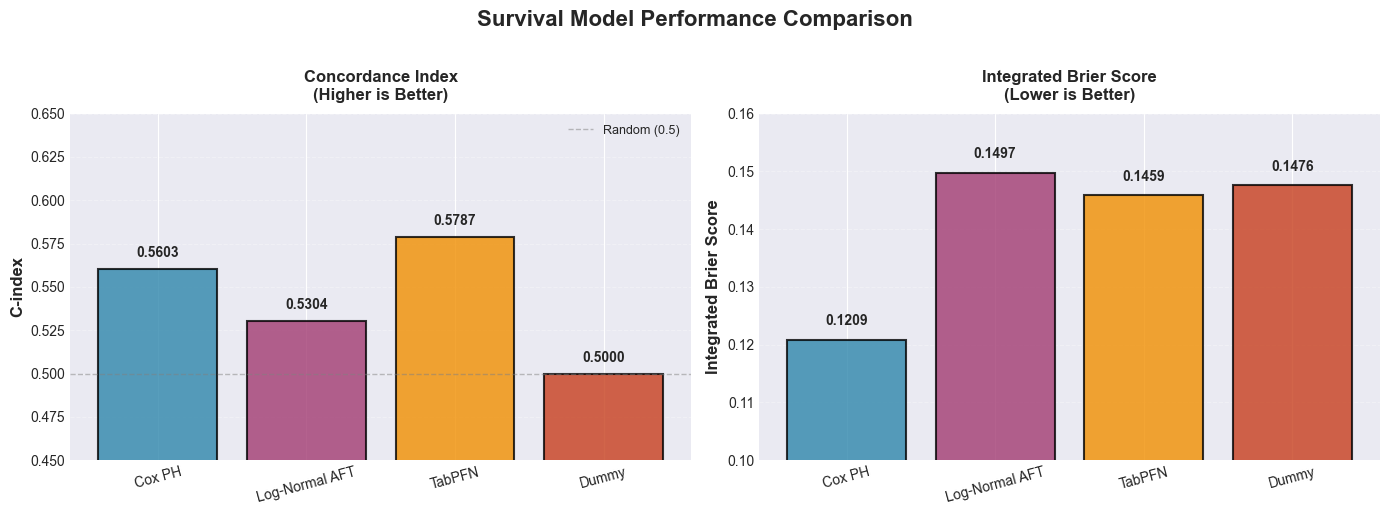

In [46]:
# Create elegant comparison plots
# Color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
model_names = comparison_data['Model'].values

# Create subplots: C-index and IBS side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Survival Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)

# Plot C-index (left subplot)
ax1 = axes[0]
bars1 = ax1.bar(model_names, comparison_data['C-index'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random (0.5)')
ax1.set_ylabel('C-index', fontsize=12, fontweight='bold')
ax1.set_title('Concordance Index\n(Higher is Better)', fontsize=12, fontweight='bold', pad=10)
ax1.set_ylim([0.45, 0.65])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.legend(fontsize=9)
for i, (bar, val) in enumerate(zip(bars1, comparison_data['C-index'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot IBS (right subplot)
ax2 = axes[1]
bars2 = ax2.bar(model_names, comparison_data['IBS'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Integrated Brier Score', fontsize=12, fontweight='bold')
ax2.set_title('Integrated Brier Score\n(Lower is Better)', fontsize=12, fontweight='bold', pad=10)
ax2.set_ylim([0.10, 0.16])
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for i, (bar, val) in enumerate(zip(bars2, comparison_data['IBS'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Format both subplots
for ax in axes:
    ax.tick_params(axis='x', rotation=15, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
